We will start with two statistical methods:
1. The dispersion index, which allows us to classify countries from the most problematic to the least problematic in terms of variability in the number of signups.
2. An outlier detection method by quartile range, which allows us to detect anomalies by timezone and by hour.

Then, we use two machine learning methods:
1. An isolation forest, which detects, for the USA, 1338 anomalies, i.e. 6% of the USA signups.
2. An autoencoder, which makes it possible to detect a desired number of anomalies, given that it depends on a threshold to be set.

Finally, we present a method, based on the autoencoder, which allows to explain anomalies.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [ ]:
pd.options.mode.chained_assignment = None

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

https://www.kaggle.com/code/quentinfu/detection-using-isolation-forest-and-autoencoder/data

In [8]:
df = pd.read_csv('./data/netflix-signups.csv')
df

,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name
0,2020-08-02 14:49:41,Italy,Europe,CET,fr-FR,Android
1,2020-08-16 07:03:09,Vietnam,Asia,Europe/Moscow,hy-am,Windows
2,2020-08-02 02:38:36,United-States,North-America,America/Los_Angeles,en-US,Windows
3,2020-08-19 05:39:47,Taiwan,Asia,Asia/Taipei,zh-TW,Windows
4,2020-08-25 21:16:09,United-States,North-America,America/Los_Angeles,en-us,iOS
...,...,...,...,...,...,...
99995,2020-08-08 12:26:56,India,Asia,Asia/Calcutta,en-US,Android
99996,2020-08-13 09:29:55,Brazil,South-America,America/Sao_Paulo,pt-BR,Windows
99997,2020-08-04 14:17:04,Italy,Europe,NaN,it-IT,iOS
99998,2020-08-23 22:13:04,Sweden,Europe,UTC,en-US,Mac OS


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   timestamp           100000 non-null  object
 1   ip_country          99767 non-null   object
 2   ip_continent        99767 non-null   object
 3   js_timezone         85602 non-null   object
 4   http_lang           99961 non-null   object
 5   http_platform_name  99632 non-null   object
dtypes: object(6)
memory usage: 4.6+ MB


In [10]:
df.timestamp = pd.to_datetime(df.timestamp)
df['date'] = df.timestamp.dt.date #We create the column date that contains the date of the signup
df = df.assign(timestamp_H=df.timestamp.dt.round('H')) #We create the column timestamp_H that contains the date and the hour
df['COUNT'] = 1 #We will use this count variable in many groupby functions below.
df

,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name,date,timestamp_H,COUNT
0,2020-08-02 14:49:41,Italy,Europe,CET,fr-FR,Android,2020-08-02,2020-08-02 15:00:00,1
1,2020-08-16 07:03:09,Vietnam,Asia,Europe/Moscow,hy-am,Windows,2020-08-16,2020-08-16 07:00:00,1
2,2020-08-02 02:38:36,United-States,North-America,America/Los_Angeles,en-US,Windows,2020-08-02,2020-08-02 03:00:00,1
3,2020-08-19 05:39:47,Taiwan,Asia,Asia/Taipei,zh-TW,Windows,2020-08-19,2020-08-19 06:00:00,1
4,2020-08-25 21:16:09,United-States,North-America,America/Los_Angeles,en-us,iOS,2020-08-25,2020-08-25 21:00:00,1
...,...,...,...,...,...,...,...,...,...
99995,2020-08-08 12:26:56,India,Asia,Asia/Calcutta,en-US,Android,2020-08-08,2020-08-08 12:00:00,1
99996,2020-08-13 09:29:55,Brazil,South-America,America/Sao_Paulo,pt-BR,Windows,2020-08-13,2020-08-13 09:00:00,1
99997,2020-08-04 14:17:04,Italy,Europe,NaN,it-IT,iOS,2020-08-04,2020-08-04 14:00:00,1
99998,2020-08-23 22:13:04,Sweden,Europe,UTC,en-US,Mac OS,2020-08-23,2020-08-23 22:00:00,1


# 1. Data analysis and statistical models

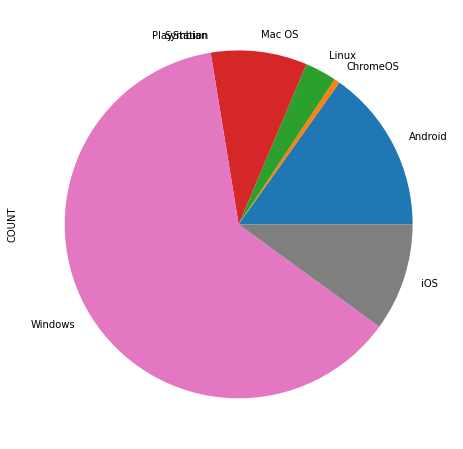

In [15]:
df.groupby('http_platform_name').count()['COUNT'].plot.pie(figsize=(15,8)); plt.show()

The vast majority of signups are done with Windows.
We can easily imagine that the fake accounts are created by bots, which are likely used on desktop OS: Windows, Linux and Mac OS.  
Note that this assumption works only if the user agents match the machine (it is actually possible to change the user agent in the web browser). For this reason, we will first work with these 3 platforms:

In [16]:
df = df.loc[df.http_platform_name.isin(['Linux', 'Mac OS', 'Windows'])]
df

,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name,date,timestamp_H,COUNT
1,2020-08-16 07:03:09,Vietnam,Asia,Europe/Moscow,hy-am,Windows,2020-08-16,2020-08-16 07:00:00,1
2,2020-08-02 02:38:36,United-States,North-America,America/Los_Angeles,en-US,Windows,2020-08-02,2020-08-02 03:00:00,1
3,2020-08-19 05:39:47,Taiwan,Asia,Asia/Taipei,zh-TW,Windows,2020-08-19,2020-08-19 06:00:00,1
5,2020-07-31 13:32:41,Estonia,Europe,Europe/Tallinn,"en,et",Windows,2020-07-31,2020-07-31 14:00:00,1
6,2020-07-31 08:41:37,United-States,North-America,Africa/Lagos,en-US,Windows,2020-07-31,2020-07-31 09:00:00,1
...,...,...,...,...,...,...,...,...,...
99993,2020-08-17 11:22:40,Kazakhstan,Asia,Europe/Moscow,fr-dz,Windows,2020-08-17,2020-08-17 11:00:00,1
99994,2020-08-15 10:03:10,Singapore,Asia,Asia/Singapore,en-US,Mac OS,2020-08-15,2020-08-15 10:00:00,1
99996,2020-08-13 09:29:55,Brazil,South-America,America/Sao_Paulo,pt-BR,Windows,2020-08-13,2020-08-13 09:00:00,1
99998,2020-08-23 22:13:04,Sweden,Europe,UTC,en-US,Mac OS,2020-08-23,2020-08-23 22:00:00,1


A first overview of the data is made by looking at the number of signups per day and per continent.

## 1.1. Study of the number of signups per day

In [18]:
df.pivot_table(index = 'date', columns = 'ip_continent', aggfunc = 'count').COUNT

ip_continent,Africa,Asia,Europe,North-America,Oceania,South-America
date,,,,,,
2020-07-28,122,587,851,718,53,147
2020-07-29,125,614,821,836,52,142
2020-07-30,99,555,763,827,51,120
2020-07-31,87,400,733,736,52,139
2020-08-01,142,648,684,649,49,162
2020-08-02,127,804,748,695,35,141
2020-08-03,134,853,760,783,63,191
2020-08-04,137,790,882,858,55,188
2020-08-05,109,807,867,821,56,176


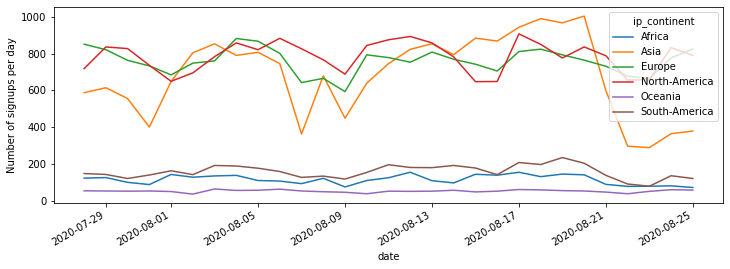

In [22]:
df.pivot_table(index = 'date', columns = 'ip_continent', aggfunc = 'count').COUNT.plot(figsize=(12,4))
plt.gcf().autofmt_xdate(); 
plt.ylabel('Number of signups per day'); plt.show()

#### 1.1.1 Index dispersion

It seems that countries in Asia are subject to the most variations. The use of the dispersion index by day and country confirms this; Asian countries have the largest index dispersion, as we can see below:

In [25]:
df.head()

,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name,date,timestamp_H,COUNT
1,2020-08-16 07:03:09,Vietnam,Asia,Europe/Moscow,hy-am,Windows,2020-08-16,2020-08-16 07:00:00,1
2,2020-08-02 02:38:36,United-States,North-America,America/Los_Angeles,en-US,Windows,2020-08-02,2020-08-02 03:00:00,1
3,2020-08-19 05:39:47,Taiwan,Asia,Asia/Taipei,zh-TW,Windows,2020-08-19,2020-08-19 06:00:00,1
5,2020-07-31 13:32:41,Estonia,Europe,Europe/Tallinn,"en,et",Windows,2020-07-31,2020-07-31 14:00:00,1
6,2020-07-31 08:41:37,United-States,North-America,Africa/Lagos,en-US,Windows,2020-07-31,2020-07-31 09:00:00,1


In [26]:
df.groupby(['ip_country', 'date']).count()

timestamp  ip_continent  js_timezone  http_lang  \
ip_country  date                                                          
Afghanistan 2020-07-28          1             1            1          1   
            2020-08-02          2             2            2          2   
            2020-08-03          2             2            2          2   
            2020-08-15          1             1            1          1   
            2020-08-16          1             1            1          1   
...                           ...           ...          ...        ...   
Zimbabwe    2020-08-16          2             2            2          2   
            2020-08-17          4             4            4          4   
            2020-08-19          1             1            1          1   
            2020-08-21          1             1            1          1   
            2020-08-23          2             2            2          2   

                        http_platform_name  timestamp_H  COUNT  
ip_country  date                                                
Afghanistan 2020-07-28                   1            1      1  
            2020-08-02                   2            2      2  
            2020-08-03                   2            2      2  
            2020-08-15                   1            1      1  
            2020-08-16                   1            1      1  
...                                    ...          ...    ...  
Zimbabwe    2020-08-16                   2            2      2  
            2020-08-17                   4            4      4  
            2020-08-19                   1            1      1  
            2020-08-21                   1            1      1  
            2020-08-23                   2            2      2  

[3369 rows x 7 columns]

In [30]:
df1 = df.groupby(['ip_country', 'date']).count().COUNT
df1

ip_country   date      
Afghanistan  2020-07-28    1
             2020-08-02    2
             2020-08-03    2
             2020-08-15    1
             2020-08-16    1
                          ..
Zimbabwe     2020-08-16    2
             2020-08-17    4
             2020-08-19    1
             2020-08-21    1
             2020-08-23    2
Name: COUNT, Length: 3369, dtype: int64

In [34]:
df1.groupby(['ip_country']).var()

ip_country
Afghanistan       0.214286
Albania           4.267806
Algeria          20.935961
Andorra           3.333333
Angola            0.000000
                  ...     
Venezuela        14.881773
Vietnam        4620.423645
Yemen             0.238095
Zambia            0.214286
Zimbabwe          0.809524
Name: COUNT, Length: 195, dtype: float64

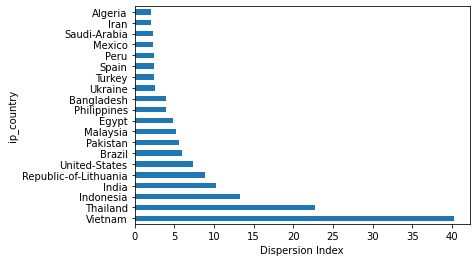

In [35]:
df1 = df.groupby(['ip_country', 'date']).count().COUNT
dispersion_index = (df1.groupby(['ip_country']).var()/df1.groupby(['ip_country']).mean()).sort_values(ascending = False)
dispersion_index[:20].plot.barh(); plt.xlabel('Dispersion Index'); plt.show()

However, looking at the number of connections per day is not granular enough. Below, we look at the number of registrations for each hour, and for the entire world.
What should be noted is that a **dependence on the hour in the day** appears, although we have here all the time zones mixed together.

## 1.2 Study of the number of signups per hour

In [37]:
df.groupby([df.timestamp_H]).count().COUNT

timestamp_H
2020-07-28 02:00:00     82
2020-07-28 03:00:00     90
2020-07-28 04:00:00     84
2020-07-28 05:00:00     82
2020-07-28 06:00:00     66
                      ... 
2020-08-25 20:00:00     92
2020-08-25 21:00:00     91
2020-08-25 22:00:00    103
2020-08-25 23:00:00    105
2020-08-26 00:00:00     42
Name: COUNT, Length: 695, dtype: int64

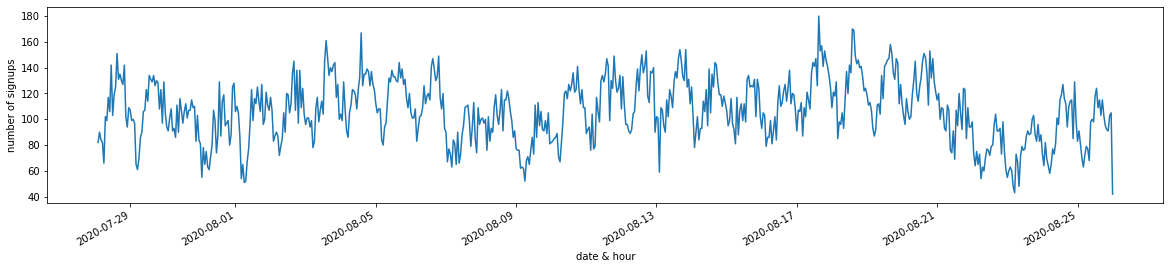

In [39]:
fig=plt.figure(figsize=(20,4))
plt.plot(df.groupby([df.timestamp_H]).count().COUNT)
plt.xlabel('date & hour'); plt.ylabel('number of signups'); plt.gcf().autofmt_xdate(); plt.show()

To confirm this dependence, we look at the number of signups per hour on average, for each continent, then for a few timezones:

___________________________________CONTINENTS___________________________________


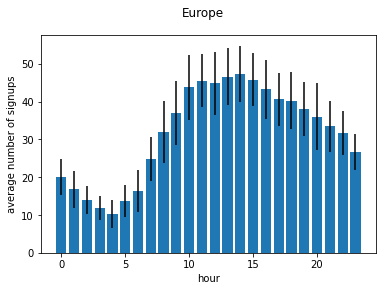

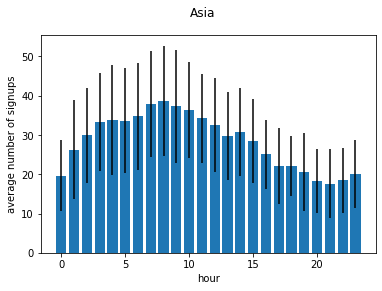

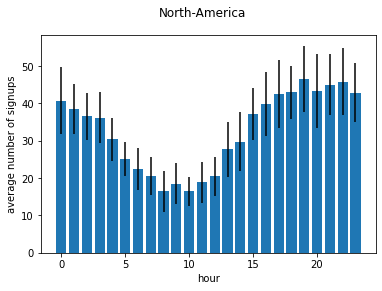

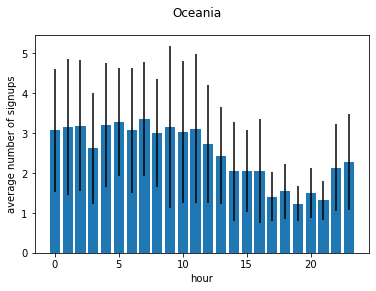

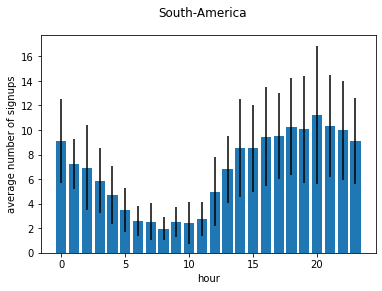

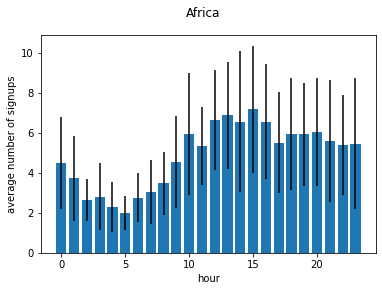

___________________________________TIMEZONES___________________________________


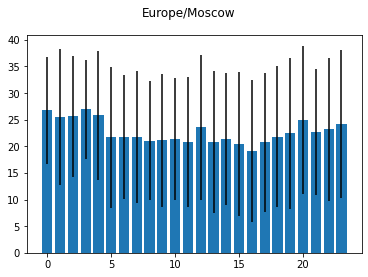

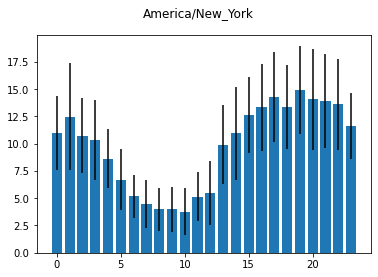

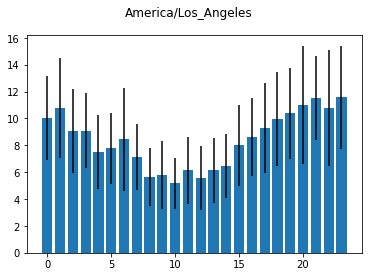

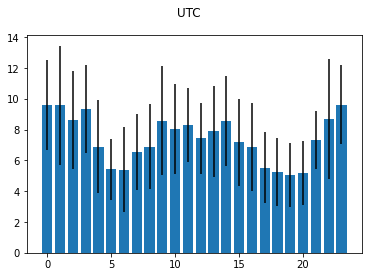

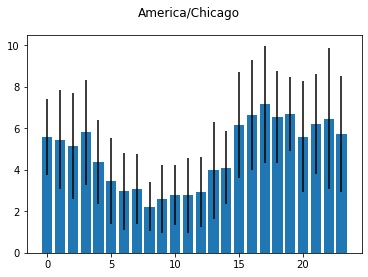

In [40]:
print('___________________________________CONTINENTS___________________________________')
for continent in ['Europe', 'Asia', 'North-America', 'Oceania', 'South-America','Africa']:
    df_continent = df.loc[df.ip_continent == continent]
    df_continent_per_date_hour = df_continent.groupby([df_continent.timestamp_H]).count()[['COUNT']].reset_index()
    groupby_hour = df_continent_per_date_hour.groupby(df_continent_per_date_hour.timestamp_H.dt.hour).COUNT
    mean_per_hour = groupby_hour.mean()
    std_per_hour  = groupby_hour.std()   
    fig, ax = plt.subplots()
    ax.bar(mean_per_hour.index, height = mean_per_hour.values, yerr = std_per_hour.values)
    fig.suptitle(continent); ax.set_xlabel('hour'); ax.set_ylabel('average number of signups')
plt.show()

print('___________________________________TIMEZONES___________________________________')

for timezone in df.js_timezone.value_counts().index[:5]:
    df_timezone = df.loc[df.js_timezone == timezone]
    df_timezone_per_date_hour = df_timezone.groupby([df_timezone.timestamp_H]).count()[['COUNT']].reset_index()
    groupby_hour = df_timezone_per_date_hour.groupby(df_timezone_per_date_hour.timestamp_H.dt.hour).COUNT
    mean_per_hour = groupby_hour.mean()
    std_per_hour  = groupby_hour.std()
    fig, ax = plt.subplots()
    ax.bar(mean_per_hour.index, height = mean_per_hour.values, yerr = std_per_hour.values)
    fig.suptitle(timezone)
    plt.show()

#### 1.2.1 Quartiles method

Seeing this, a first method of detecting "anomalies" is to treat as outlier any number of signup that falls outside the interval [Q1 - coef * IQR; Q1 + coef * IQR], where Q1 is the 25% quartile, Q3 the 75% quartile, and IQR is the interquartile range. Q1, Q3 and IQR are defined by hour and timezone or country.

In [43]:
import warnings # 파이썬 버전에 따른 오류 출력 방지
warnings.filterwarnings('ignore')

In [44]:
coeff_IQR = 1.5
s = 0

df_errors_inf = pd.DataFrame() #Contains the list of abnormally low values 
df_errors_sup = pd.DataFrame() #Contains the list of abnormally high values

for timezone in df.js_timezone.unique(): #We work with timezones
    df_timezone = df.loc[df.js_timezone == timezone]
    count_per_timestamp = df_timezone.groupby("timestamp").count()[['COUNT']].reset_index()
    
    
    df_timezone['hour'] = df_timezone.timestamp.dt.hour
    
    count_per_timestamp['hour'] = count_per_timestamp.timestamp.dt.hour
    
    groupby_hour = count_per_timestamp.groupby('hour').COUNT
    Q1 = groupby_hour.quantile(0.25)
    Q3  = groupby_hour.quantile(0.75)
    mean_per_hour = groupby_hour.mean()
    IQR = Q3-Q1
    count_per_timestamp.set_index('hour', inplace = True)
    count_per_timestamp['LB'] = np.min(Q1 - coeff_IQR*IQR, 0)
    count_per_timestamp['UB'] = Q3 + coeff_IQR*IQR
    count_per_timestamp['mean'] = mean_per_hour
    
    
    df_errors_inf_timezone = count_per_timestamp.loc[(count_per_timestamp.COUNT < count_per_timestamp['LB'])]
    df_errors_sup_timezone = count_per_timestamp.loc[(count_per_timestamp.COUNT > count_per_timestamp['UB'])]
    
    
    df_errors_inf_timezone['timezone'] = timezone
    df_errors_sup_timezone['timezone'] = timezone

    
    df_errors_inf = pd.concat([df_errors_inf, df_errors_inf_timezone])
    df_errors_sup = pd.concat([df_errors_sup, df_errors_sup_timezone])

In [45]:
df_errors_inf.head()

,timestamp,COUNT,LB,UB,mean,timezone
hour,,,,,,


In [46]:
df_errors_sup.head()

,timestamp,COUNT,LB,UB,mean,timezone
hour,,,,,,
19,2020-07-29 19:45:36,2,1.0,1.0,1.009569,Europe/Moscow
1,2020-07-30 01:21:45,2,1.0,1.0,1.005291,Europe/Moscow
6,2020-07-30 06:26:34,2,1.0,1.0,1.007105,Europe/Moscow
9,2020-07-30 09:17:46,2,1.0,1.0,1.003390,Europe/Moscow
11,2020-07-30 11:03:46,2,1.0,1.0,1.004815,Europe/Moscow


First, with this method, we are not able to detect low signups, df_errors_inf being empty.

Then, we observe that we detect anomalies when, for example, the count is 2 whereas it is most of the time 1, which is however probably not an anomaly.

It seems that using only statistical methods is not enough to correctly detect anomalies. For this reason, we are now going to use **machine learning techniques**.

# 2. Focus on the USA

With the USA being the country where the majority of signups come from, we are now focusing on that country only. Indeed, I am assuming here that the creation of fake accounts or the problems of creating accounts are independent between the countries.

We no longer restrict ourselves to desktop OS, but keep the most used platforms. We can afford it since we have limited the dimensions of the problem by keeping only one country.

We will use two machine learning algorithms to detect unexpectedly high or low signups: An Isolation forest and an autoencoder.
Because we use here two unsupervised machine learning methods, there is no need to split the data set into a train part and a test part.

## 2.1. Preprocessing

In [87]:
df = pd.read_csv('./data/netflix-signups.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df['date'] = df.timestamp.dt.date
df = df.assign(timestamp_H=df.timestamp.dt.round('H'))
df['COUNT'] = 1
df = df.loc[df.http_platform_name.isin(['Linux', 'Mac OS', 'Windows', 'iOS', 'Android'])]
df = df.loc[df.ip_country == 'United-States']
df.head()

,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name,date,timestamp_H,COUNT
2,2020-08-02 02:38:36,United-States,North-America,America/Los_Angeles,en-US,Windows,2020-08-02,2020-08-02 03:00:00,1
4,2020-08-25 21:16:09,United-States,North-America,America/Los_Angeles,en-us,iOS,2020-08-25,2020-08-25 21:00:00,1
6,2020-07-31 08:41:37,United-States,North-America,Africa/Lagos,en-US,Windows,2020-07-31,2020-07-31 09:00:00,1
12,2020-07-31 17:51:31,United-States,North-America,America/New_York,en-US,Android,2020-07-31,2020-07-31 18:00:00,1
14,2020-08-24 07:49:46,United-States,North-America,America/Los_Angeles,en-US,Windows,2020-08-24,2020-08-24 08:00:00,1


In order to reduce the dimensionality of the data, which is mainly due to categorical data, we remove from our data the categorical data that is not very present (i.e. with less than 100 observations)

In [88]:
df.js_timezone.value_counts()

America/New_York       7553
America/Los_Angeles    5279
America/Chicago        3840
UTC                    1111
America/Denver          749
                       ... 
America/Matamoros         1
Etc/GMT3                  1
America/Whitehorse        1
Europe/Vilnius            1
Europe/Helsinki           1
Name: js_timezone, Length: 208, dtype: int64

In [89]:
timezone_USAs = df.js_timezone.value_counts()
timezones_to_use = timezone_USAs.loc[timezone_USAs > 100].index.values #We only select timezones that appear more than 100 times

df.http_lang = df.http_lang.str.lower()
df.http_lang = df.http_lang.str.replace('-', '_') #We preprocess a little the language data
lang_USAs = df.http_lang.value_counts()
languages_to_use = lang_USAs.loc[lang_USAs > 100].index.values #We only select languages that appear more than 100 times

df = df.loc[df.js_timezone.isin(timezones_to_use) & df.http_lang.isin(languages_to_use)] 
df.head()

,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name,date,timestamp_H,COUNT
2,2020-08-02 02:38:36,United-States,North-America,America/Los_Angeles,en_us,Windows,2020-08-02,2020-08-02 03:00:00,1
4,2020-08-25 21:16:09,United-States,North-America,America/Los_Angeles,en_us,iOS,2020-08-25,2020-08-25 21:00:00,1
6,2020-07-31 08:41:37,United-States,North-America,Africa/Lagos,en_us,Windows,2020-07-31,2020-07-31 09:00:00,1
12,2020-07-31 17:51:31,United-States,North-America,America/New_York,en_us,Android,2020-07-31,2020-07-31 18:00:00,1
14,2020-08-24 07:49:46,United-States,North-America,America/Los_Angeles,en_us,Windows,2020-08-24,2020-08-24 08:00:00,1


An anomaly is not linked to a single signup, but to several close signups, either temporally or spatially. To take this into account, we need to add columns containing the number of signups in the same time window, and by similarity of country, language, timezone, and platform. We add these columns with the code below:

In [90]:
def sum_per_t(df, t):
    """
    Add 4 columns in the dataset that contains the count of signups in the time interval (that can be hour, day, ...)
    And for each granularity (country, country and same language, country and same timezone, country and same platforme)
    """
    df = df.set_index(df.timestamp.dt.round(t))
    df['count_' + t] = df.groupby([df.timestamp.dt.round(t)]).COUNT.count()
    
    for granularity in ['http_lang', 'js_timezone', 'http_platform_name']:
        df = df.set_index([df.timestamp.dt.round(t), granularity])
        df['count_' + t + '_' + granularity] = df.groupby([df.timestamp.dt.round(t), granularity]).COUNT.count()
        df = df.reset_index(level = 1)
    return df
  
df2 = sum_per_t(df, 'D') #Add the number of signups in the day
df2 = sum_per_t(df2, 'H') #Add the number of signups in the hour
df2 = sum_per_t(df2, 'min') #Add the number of signups in the minute
df2 = sum_per_t(df2, 's') #Add the number of signups in the second

df2['hour'] = df2.timestamp.dt.hour #We add a column that contains the hour in the day
df2['weekday'] = df2.timestamp.dt.weekday #We add a column that contains the week day

To use machine learning algorithms on this data, we need to use one-hot-encoding on categorical columns:

In [91]:
df_study = df2[['http_platform_name', 'js_timezone', 'http_lang', 'hour',
       'weekday', 'count_D', 'count_D_http_lang', 'count_D_js_timezone',
       'count_D_http_platform_name', 'count_H', 'count_H_http_lang',
       'count_H_js_timezone', 'count_H_http_platform_name', 'count_min',
       'count_min_http_lang', 'count_min_js_timezone',
       'count_min_http_platform_name', 'count_s', 'count_s_http_lang',
       'count_s_js_timezone', 'count_s_http_platform_name']]

df_dum = pd.get_dummies(df_study)
df_dum.head()

,hour,weekday,count_D,count_D_http_lang,count_D_js_timezone,count_D_http_platform_name,count_H,count_H_http_lang,count_H_js_timezone,count_H_http_platform_name,...,js_timezone_Asia/Calcutta,js_timezone_Asia/Shanghai,js_timezone_Europe/Moscow,js_timezone_UTC,http_lang_en_gb,http_lang_en_us,http_lang_es_es,http_lang_pt_br,http_lang_ru_ru,http_lang_zh_cn
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-02 02:38:36,2,6,600,587,144,383,28,28,8,20,...,0,0,0,0,0,1,0,0,0,0
2020-08-25 21:16:09,21,1,404,394,98,56,41,40,11,3,...,0,0,0,0,0,1,0,0,0,0
2020-07-31 08:41:37,8,4,709,689,3,450,25,24,1,20,...,0,0,0,0,0,1,0,0,0,0
2020-07-31 17:51:31,17,4,661,631,250,62,33,30,14,4,...,0,0,0,0,0,1,0,0,0,0
2020-08-24 07:49:46,7,0,621,601,187,380,11,10,3,8,...,0,0,0,0,0,1,0,0,0,0


## 2.2. Isolation forest
An isolation forest is an unsupervised learning algorithm for anomaly detection that works on the principle of isolating anomalies. The advantage of this method is that it directly gives the anomalies it detects, and labels them -1.

In [92]:
clf = IsolationForest(random_state = 42)
preds = clf.fit_predict(df_dum)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [93]:
print('Signups detected as abnormal by the isolation forest:')
df.loc[preds == -1]

Signups detected as abnormal by the isolation forest:


,timestamp,ip_country,ip_continent,js_timezone,http_lang,http_platform_name,date,timestamp_H,COUNT
24,2020-08-08 03:14:20,United-States,North-America,Asia/Shanghai,zh_cn,Mac OS,2020-08-08,2020-08-08 03:00:00,1
73,2020-08-06 00:07:50,United-States,North-America,America/Chicago,en_us,iOS,2020-08-06,2020-08-06 00:00:00,1
364,2020-08-18 15:19:56,United-States,North-America,Asia/Shanghai,zh_cn,Windows,2020-08-18,2020-08-18 15:00:00,1
536,2020-08-04 01:34:17,United-States,North-America,America/New_York,en_us,Windows,2020-08-04,2020-08-04 02:00:00,1
614,2020-08-19 02:42:48,United-States,North-America,America/Los_Angeles,en_us,Windows,2020-08-19,2020-08-19 03:00:00,1
...,...,...,...,...,...,...,...,...,...
99566,2020-08-06 22:41:29,United-States,North-America,America/Los_Angeles,en_us,Windows,2020-08-06,2020-08-06 23:00:00,1
99704,2020-08-23 23:25:07,United-States,North-America,Africa/Lagos,en_gb,Windows,2020-08-23,2020-08-23 23:00:00,1
99725,2020-08-05 19:46:50,United-States,North-America,UTC,en_us,Linux,2020-08-05,2020-08-05 20:00:00,1
99834,2020-08-17 13:10:18,United-States,North-America,America/Phoenix,en_us,Windows,2020-08-17,2020-08-17 13:00:00,1


Using the isolation forest, with the default hyperparameters, we find **1338 anomalies**, i.e. **6% of the data**. 


However, although we have detected anomalies, we do not know if they are credible, as we do not have an explanation of the model. 
A method explained in the article "Explaining Anomalies Detected by Autoencoders Using SHAP" (https://arxiv.org/abs/1903.02407) by Liat Antwarg, Bracha Shapira and Lior Rokach proposes a method allowing to explain why an anomaly is detected as such.


## 이 사이트도 참고하길!
- https://heka-ai.medium.com/detection-and-interpretation-of-outliers-thanks-to-autoencoder-and-shap-values-dae99b89b80f

## 2.3. Autoencoder

To use this method, we must first build an autoencoder.

We start by building an autoencoder, which from the reconstruction error, allows us to find the anomalies (the anomalies are the observations for which the reconstruction error is beyond a threshold to be defined).
Then, we use SHAP to explain which are the features which contribute to increase and decrease the reconstruction error.

Thanks to this, we will know which features are unexpected, and explain that the observation is an anomaly.

In [94]:
pipeline = Pipeline([('normalizer', Normalizer()), ('scaler', MinMaxScaler())]) #Because we use an autoencoder, 
#which is a neural network based model, we have to standardize data.

df_dum_transformed = pipeline.fit_transform(df_dum)

In [95]:
input_dim = df_dum_transformed.shape[1]
latent_dim = 10
BATCH_SIZE = 256
EPOCHS = 30

autoencoder = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim, )), 
        
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    
    tf.keras.layers.Dense(input_dim, activation='relu')
    
])

autoencoder.compile(optimizer='adam', 
                    loss='mse',
                    metrics=['acc'])

# print an overview of our model
autoencoder.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 12)                492       
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 40)                520       
                                                                 
Total params: 2,808
Trainable params: 2,808
Non-trainable params: 0
_________________________________________________________________


In [96]:
EPOCHS = 50
BATCH_SIZE = 32

history = autoencoder.fit(
    df_dum_transformed, df_dum_transformed,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
);

Epoch 1/50
629/629 [==============================] - 1s 716us/step - loss: 0.0297 - acc: 0.0241
Epoch 2/50
629/629 [==============================] - 0s 716us/step - loss: 0.0244 - acc: 0.0343
Epoch 3/50
629/629 [==============================] - 0s 723us/step - loss: 0.0240 - acc: 0.0366
Epoch 4/50
629/629 [==============================] - 0s 707us/step - loss: 0.0238 - acc: 0.0378
Epoch 5/50
629/629 [==============================] - 0s 691us/step - loss: 0.0237 - acc: 0.0393
Epoch 6/50
629/629 [==============================] - 0s 710us/step - loss: 0.0237 - acc: 0.0396
Epoch 7/50
629/629 [==============================] - 0s 734us/step - loss: 0.0236 - acc: 0.0399
Epoch 8/50
629/629 [==============================] - 0s 715us/step - loss: 0.0236 - acc: 0.0397
Epoch 9/50
629/629 [==============================] - 0s 690us/step - loss: 0.0236 - acc: 0.0402
Epoch 10/50
629/629 [==============================] - 0s 721us/step - loss: 0.0235 - acc: 0.0405
Epoch 11/50
629/629 [========

In [97]:
reconstructions = autoencoder.predict(df_dum_transformed)
reconstructions

array([[0.        , 0.61432755, 0.04985651, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1521972 , 0.26303837, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.34570408, 0.08548935, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.64251405, 0.24514961, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.34610552, 0.06961417, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04807761, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [98]:
from IPython.core.interactiveshell import InteractiveShell # 모든 명령어 출력
InteractiveShell.ast_node_interactivity = 'all'

In [99]:
pd.DataFrame(df_dum_transformed - reconstructions)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.041759,0.005683,-0.006389,0.897060,-0.005380,-0.007719,-0.005263,-0.000433,0.005234,0.014053,...,0.0,0.0,0.0,0.0,0.0,-0.002240,0.0,0.0,0.0,0.0
1,0.708191,0.014704,-0.069317,0.972627,0.007828,0.154330,0.009998,0.007582,0.011517,-0.069874,...,0.0,0.0,0.0,0.0,0.0,0.017481,0.0,0.0,0.0,0.0
2,0.143663,0.009801,-0.013999,0.905622,-0.015900,-0.013230,-0.010697,-0.014116,0.002782,0.026232,...,0.0,0.0,0.0,0.0,0.0,0.001899,0.0,0.0,0.0,0.0
3,0.349037,0.006839,0.007876,0.948320,0.000341,-0.007960,0.009243,-0.014996,-0.002342,0.017652,...,0.0,0.0,0.0,0.0,0.0,-0.008529,0.0,0.0,0.0,0.0
4,0.141955,0.000000,0.003455,0.892050,0.012475,0.001400,0.003711,0.001604,-0.005936,0.004087,...,0.0,0.0,0.0,0.0,0.0,0.009394,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20108,0.377205,0.010252,0.015356,0.894203,0.033830,-0.022533,-0.001532,-0.012964,-0.020781,0.059165,...,0.0,0.0,0.0,0.0,0.0,-0.016241,0.0,0.0,0.0,0.0
20109,0.396804,0.008321,0.016309,0.944664,-0.021250,-0.015813,-0.003330,0.001115,0.015866,-0.021055,...,0.0,0.0,0.0,0.0,0.0,-0.011965,0.0,0.0,0.0,0.0
20110,0.311327,0.017828,-0.013848,0.984851,-0.002938,-0.053218,-0.004504,-0.002248,0.007092,0.014785,...,0.0,0.0,0.0,0.0,0.0,-0.020102,0.0,0.0,0.0,0.0
20111,0.124710,0.006583,-0.011946,0.898435,-0.006960,-0.002722,0.003803,0.010503,-0.000034,-0.016906,...,0.0,0.0,0.0,0.0,0.0,-0.002759,0.0,0.0,0.0,0.0


In [100]:
np.square(df_dum_transformed - reconstructions).shape
np.mean(np.square(df_dum_transformed - reconstructions), axis = 1).shape

(20113, 40)

(20113,)

In [102]:
mse = np.mean(np.square(df_dum_transformed - reconstructions), axis = 1)

<AxesSubplot:ylabel='Density'>

Text(0.5, 0.98, 'MSE on the test set for the autoencoder')

Text(0.5, 0, 'MSE')

Text(0, 0.5, 'Distribution (orinal scale)')

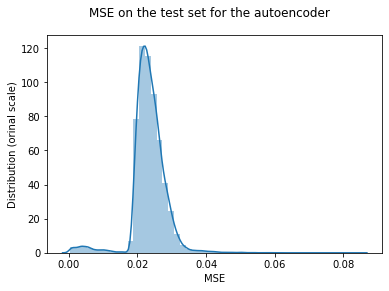

In [104]:
sns.distplot(mse); plt.suptitle('MSE on the test set for the autoencoder'); plt.xlabel('MSE'); plt.ylabel('Distribution (orinal scale)'); plt.show()

<AxesSubplot:ylabel='Density'>

Text(0.5, 0.98, 'MSE on the test set for the autoencoder')

Text(0.5, 0, 'MSE')

Text(0, 0.5, 'Distribution (log scale)')

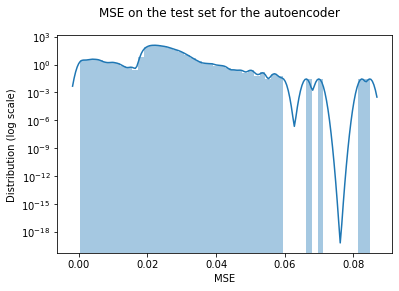

In [101]:
sns.distplot(mse); plt.yscale('log'); plt.suptitle('MSE on the test set for the autoencoder'); plt.xlabel('MSE'); plt.ylabel('Distribution (log scale)'); plt.show()

SHAP is very slow to execute, so we have to limit the execution of the algorithm to a small amount of data. For this, we select the 27 observations which have the greatest reconstruction error:

In [106]:
print(np.sum(mse > 0.05), 'observations have a reconstruction error greater than 0.05')
df_bigger_anomalies = df_dum_transformed[mse > 0.05]
pd.DataFrame(df_bigger_anomalies)
df_bigger_anomalies

22 observations have a reconstruction error greater than 0.05


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.444044,0.313948,0.247824,0.975141,0.065629,0.132229,0.501810,0.637077,0.058161,0.159502,...,0.0,0.0,0.0,0.000000,0.000000,0.994111,0.0,0.000000,0.0,0.0
1,0.167371,0.414171,0.861044,0.016955,0.703441,0.142216,1.000000,0.071873,1.000000,0.035593,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0
2,0.252126,0.311951,0.235608,0.968931,0.065197,0.131260,0.767721,1.000000,0.211184,0.124982,...,0.0,0.0,0.0,0.000000,0.000000,0.987789,0.0,0.000000,0.0,0.0
3,0.435622,0.307993,0.211391,0.956619,0.522515,0.100589,0.491526,0.624816,0.359829,0.156309,...,0.0,0.0,0.0,0.000000,0.000000,0.975256,0.0,0.000000,0.0,0.0
4,0.951159,0.235371,0.959551,0.012496,0.029528,0.221518,0.717155,0.013734,0.038827,0.243565,...,0.0,0.0,0.0,0.000000,0.568362,0.000000,0.0,0.000000,0.0,0.0
5,0.499611,0.309080,0.218043,0.960001,0.524367,0.101015,0.250786,0.324008,0.209065,0.024324,...,0.0,0.0,0.0,0.000000,0.000000,0.978699,0.0,0.000000,0.0,0.0
6,0.185427,0.305902,0.198594,0.950113,0.518951,0.099769,0.752050,0.980426,0.884135,0.220790,...,0.0,0.0,0.0,0.000000,0.000000,0.968634,0.0,0.000000,0.0,0.0
7,0.499831,0.309216,0.218876,0.960424,0.524599,0.101069,0.202369,0.263518,0.133081,0.057495,...,0.0,0.0,0.0,0.000000,0.000000,0.979130,0.0,0.000000,0.0,0.0
8,0.498127,0.308162,0.212426,0.957145,0.589483,0.014359,0.201541,0.262588,0.208387,0.024226,...,0.0,0.0,0.0,0.000000,0.000000,0.975792,0.0,0.000000,0.0,0.0
9,0.459607,0.284332,0.066621,0.883017,0.005388,0.770759,0.182835,0.241560,0.050874,0.204600,...,0.0,0.0,0.0,0.000000,0.000000,0.900334,0.0,0.000000,0.0,0.0


array([[0.44404371, 0.31394755, 0.24782394, 0.97514147, 0.06562934,
        0.13222883, 0.50180961, 0.63707667, 0.05816144, 0.1595018 ,
        0.63977106, 0.27625187, 0.31685063, 0.48475692, 0.43328355,
        0.43328355, 0.66953561, 0.66953561, 0.        , 0.        ,
        0.72722815, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99411124, 0.        , 0.        , 0.        , 0.        ],
       [0.16737097, 0.41417088, 0.86104393, 0.01695504, 0.70344078,
        0.14221581, 1.        , 0.07187335, 1.        , 0.03559294,
        0.87186782, 0.39230025, 1.        , 0.68839447, 0.61529808,
        0.61529808, 0.95079532, 0.95079532, 0.96112716, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0. 

In [107]:
import shap
explainer = shap.KernelExplainer(autoencoder, data = df_bigger_anomalies)

Due to a library problem, probably because of my Tensorflow version, SHAP is not able to build the explainer in the cell above. Otherwise, SHAP must be able to construct this kind of result, allowing to explain, for each output, the reason for which it is obtained:
![title](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/iris_instance.png)

A possible future work would be to:

    - Work using SHAP to understand the reasons for the anomalies.  
    - Look directly the results of the isolation forest, and, with a business knowledge, see if too many or not enough anomalies are detected. Then modify the hyperparameters of the isolation forest to match the number of desired anomalies.   